In this notebook, we will introduce how to perform DASH sampling and following MSM analysis. 

Please make sure you are running the notebook at the directory of "DASH/tutorial/02_DASH_Sampling", because we will use relative path in this notebook. 

-----------------------------------------------------------------------------------------------------------------------------------------

Conformation sampling is realized with ../../bin/DASH, a command line tool. DASH has many args, you can find them by

In [ ]:
import os
os.system("../../bin/DASH --help")

You can find that there are too much args, so that it is recommended to write a input file. An example of ADK is given here, and will be used here as the example. The input file could be found in this directory as "adk.in"

In each line, the left represents the name of arg (correspondint to the XXX of --XXX in command line) while the right is its value. 

【guide_type】: Physical function for seed selection.  bp (Binding Potential) or e (Potential Energy) or ebp (Binding Potential + Potential Enedgy)

【method_name】: The method used for dimension reduction, including SplitContrastMAE, PCA, UMAP, IsoMap, AE (AutoEncoder) and EncoderMap. 

【high_dim_type】: Atoms selected to describe your reprersent your trajectory during dimension redcution. In out article we use "CA", namely Cα atoms. The program also support "heavy", namely all heavy atoms. 

【traj_info】: A file describing basic input, will be discussed later. 

【cuda_id】: GPU ID to run DASH

【round_time】: Simulation time in each round. Unit: ns.

【max_round】: Maximum round number. Start with 0. So if max_round = 2, DASH will run 3 rounds. 1 round of CMD and 2 rounds of seeded sampling.

【msr】: Methods to split residues. 0: cluster flexible regions 1: cluster flexible regions & skip ter 2:top flexible regions 3:top flexible regions & skip ter 4: linear_related_to_all flexible regions 5:linear_related_to_all flexible regionsd&skip ter. In this article, msr=0 for inactive->active and idr folding, and msr=4 for cryptic allosteric site opening. 

【n_seed_drag】: Number of marginal conformations generated. Used for further hopping simulation.

【n_seed】: Number of hopped structures selected by physical functions. Used for further seeded sampling.

【rmsd_cutoff_pct】: Used to calculate the RMSD value to stop seed hopping. RMSD = rmsd_cutoff_pct percentile of pairwise RMSDs in previous traj.

【rmsd_cutoff_least_pct】: If RMSD is still smaller than the cutoff value after 10 rounds of hopping, we use a smaller cutoff value, as rmsd_cutoff_least_pct percentile of pairwise RMSDs in previous traj.

【rmsd_cutoff_min】,【rmsd_cutoff_max】: Restricting rmsd_cutoff_min <= RMSD_cutoff <= rmsd_cutoff_max in seed hopping.

【n_train】: Training neural networks could be arbitary. Therefore, we parallely train【n_train】networks and choose the best one based on loss.

【n_proc】 : Number of processors to run DASH. 

-----------------------

The following is an example of 【traj_info_file】, which describes a input information of adk_open. This file is stored in the current directory as adk_open.trajinfo.in. 

【name】:    Name of the tajectory, used to create the working directory.

【pdb】:     The PDB file of the simulation system

【prmtop】:  AMBER parameter file of the system

【inpcrd】:  AMBER style input coordinates.

【sel_str】: Prody style selection string (http://www.bahargroup.org/prody/manual/reference/atomic/select.html) to select the atoms for alignment before dimension reduction.

-----------------------

pdb,prmtop,and inpcrd file are all made by tleap in AMBER package. You can also generate these files with other tools like CHARMMGUI (https://charmm-gui.org/)

The follwoing is a Python scripts generating pdb,prmtop,inpcrd and trajinfo files.


In [ ]:
#by tleap, make sure it is in your environment
import os

name = "adk_open"
pdb_file = "4ake_open.pdb" #raw file from PDB
folder = "adk"

os.chdir(folder)
leap1 = """source leaprc.protein.ff14SB
source leaprc.gaff2
source leaprc.water.tip3p
c = loadPDB %s
solvateBox c TIP3PBOX 12
addions c Na+ 0
addions c Cl- 0
saveamberparm c %s.prmtop %s.inpcrd
savepdb c %s_amber.pdb
quit"""%(pdb_file,name,name,name)
f = open("leap1.in","w")
f.write(leap1)
f.close()
os.system("source /opt/software/amber20/amber20/amber.sh;export LD_LIBRARY_PATH=/opt/software/amber20/amber20/miniconda/lib/:$LD_LIBRARY_PATH;tleap -f leap1.in")
os.chdir("../")

traj_info = """name     %s
pdb      %s/%s_amber.pdb
prmtop   %s/%s.prmtop
inpcrd   %s/%s.inpcrd
sel_str  not resname WAT"""%(name,folder,name,folder,name,folder,name)
f = open("%s.trajinfo"%(name),"w")
f.write(traj_info)
f.close()


Ok now we have made all the input files. Let's take a short review.

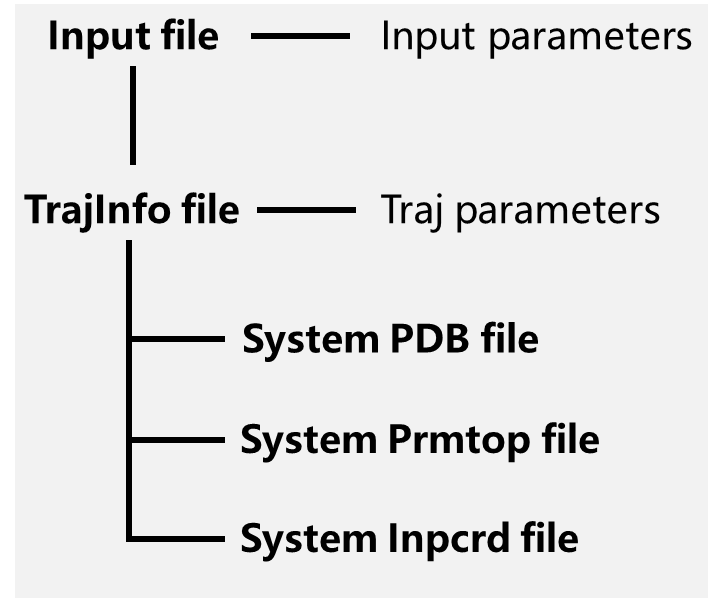

Now let's run DASH! Note that as an exa,ple, we only run a 3-round DASH. Usually it should be 20-30 rounds. But it still takes about 4 hours to finish the task

In [ ]:
import os
os.system("../../bin/DASH -i adk.in")

The up command is the same as the following in command line:

In [ ]:
import os
os.system("../../bin/DASH --guide_type ebp --method_name SplitContrastMAE --high_dim_type CA \
          --traj_info adk_open.trajinfo --cuda_id 1 --round_time 10 --max_round 2 --msr 0 --n_seed_drag 20\
          --n_seed 4 --rmsd_cutoff_pct 20 --rmsd_cutoff_least_pct 10 --rmsd_cutoff_max 2 --rmsd_cutoff_min 1\
          --n_train 5 --n_proc 8")

The above commands will result in a folder named "ebpgMD_SplitContrastMAE_CA_adk_open_rt10_nsd20_fcp01000_ecsol_msr0_pct20l10". In the folder we can find a series of subfolders with name as numbers. These represent each round of DASH simulation (start from round 0). In each subfolders are some important files:

【md.dcd】: Accumulated trajectories till this round.

【md_aligned.dcd】: A selection of md.dcd (by sel_str in traj_info_file) aligned to input structure (pdb in traj_info_file)

【z.npy】: Calculated 2-D collective variables (CVs), numpy array, n_frame*2.

【countour.jpg】: Free energy surface on CV space.

【hist.jpg】: 2-D Histogram on CV space.

【model】: Complete neural network for CV calculation. Load it by torch.load.

【CVnet_0.pt】,【CVnet_1.pt】: JIT file compiling encoders for calculating 2 CVs. 

【seedX.pdb】: X = 0~19, 20 marginal structures calculated from CV space.

【tmp】: Workdir of seed hopping. Each seedX.pdb would undergo seed hopping to a final 【dragedX.pdb】. When containing binding potential as phyiscal functions, you could also find AutoSite folders in it.

【lowe_seedX.pdb】: Selected hopped structures. Ranked from best to worse based on physical functions.

--------


Finally, we will make Markov state model (MSM) of the simulation data with the following Python codes. This requires a reduced representation of trajectory. Here, we will use CTMAE-generated CVs (z.npy). Other CVs are also OK. 

In [ ]:
import sys,os
sys.path.append("../../DASH/")
from msm import msm_and_TP

os.chdir("ebpgMD_SplitContrastMAE_CA_adk_open_rt10_nsd20_fcp01000_ecsol_msr0_pct20l10")
msm_and_TP(name="adk",ni=2,n_bins=30,z_file="z.npy")
os.chdir("..")

The MSM reweighted free energy surface will be stored as "ebpgMD_SplitContrastMAE_CA_adk_open_rt10_nsd20_fcp01000_ecsol_msr0_pct20l10/2/adk_msm_0.50ns/FES.jpg".

-----------------------

If you want to restart a simulation, you could add "restart" and "sub_restart" to the input file.

"restart X" means to restart from round X, in order performing seed hopping of marginal structures, seed selection, seeded sampling, trajectory combination and dimension reduction. 

"sub_restart Y" should be used after "restart X", meaning to restart from the Yth seeded sampling.

Here are some examples.

If you has the initial 10 ns simulation and would restart from the first dimension reduction:

If you have finished the training in round 4 and would like to restart from the seed hopping of marginal structures in round 4:

If you have finished the seeded sampling in round 4 and would like to restart from the dimension reduction step in round 4, suppose you have 4 seeds:

If you have 4 seeds in a round and use only 2 processors to run DASH. You have only finished the seeded sampling in round 4 and would like to restart the next 2 seeds: